<a href="https://colab.research.google.com/github/tithishah21/malaria-image-segmentation/blob/main/Microscopic_Counting_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PHASE 1 — DATASET UNDERSTANDING & SAMPLING**
Step 1.1 — Load and visualize images

*   Step 1.2 — Create a working subset (IMPORTANT)
*   Step 1.2 — Create a working subset (IMPORTANT)

**PHASE 2 — PREPROCESSING (OpenCV only)**
*  Step 2.1 — Convert color space
*  Step 2.2 — Noise reduction
*  Step 2.3 — Contrast enhancement (VERY IMPORTANT)
*   Step 2.4 — Thresholding
*   Step 2.5 — Morphological operations

**PHASE 3 — SEGMENTATION (CORE OF THE PAPER)**
*  Step 3.1 — Distance Transform
*  Step 3.2 — Foreground extraction
*  Step 3.3 — Marker creation
*  Step 3.4 — Watershed segmentation

**PHASE 4 — FEATURE EXTRACTION (VERY IMPORTANT)**
*   Step 4.1 — Extract contours
*   Step 4.2 — Shape features
*   Step 4.3 — Texture features (Haralick)
*   Step 4.4 — Create feature vector

**PHASE 5 — CLASSICAL ML CLASSIFICATION**
*   Step 5.1 — Train/Test split
*   Step 5.2 — Train classifiers
*   Step 5.3 — Evaluation

**PHASE 6 — FULL DATASET RUN**

**PHASE 7 — RESULTS & FIGURES (VERY IMPORTANT)**







### Project Step by Step Guide

## 1. Image Processing using OpenCV
  - Read image
  - Convert color space(for biological meaning try using HSV/LAB instead of gray since color carries biological meaning)
  - Noise reduction using blurring technique(gaussian blur / bilateral blur)
  - Contrast enhancement (using CLAHE)
  - Thresholding(binary and OTSU)
  - Morphological cleaning(removes small noise and smoothes object boundary)
  - WaterShed segmentation (to separate overlapping cells)
  link for watershed: https://docs.opencv.org/3.4/d3/db4/tutorial_py_watershed.html
    - distance transform,dilate etc
  
  ## 2. Feature Extraction

  - Convert cell masks -> meaningful numerical features

  - Shape features (OpenCV)

      Area

      Perimeter

      Circularity

      Aspect ratio

      Solidity

  - Intensity features (NumPy)

      Mean pixel intensity

      Std deviation

  - Texture features (skimage)

      GLCM contrast

      Homogeneity

      Energy

      Entropy
    
## Step 3: Dataset Formation and EDA

## Step 4: Baseline Model training(Logistic Regression, SVM and Random Forest) compare these with Ensemble Learning - Our core model (bagging and boosting)

## Step 5: HyperParameter Tuning using GridSearchCV

## Step 6: Final Evaluation using confusion matrix, feature importance plots and failure case visualization


### Step-1 : Image Processing
## below code is testing done by dipit.. can remove once we start doing the project

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

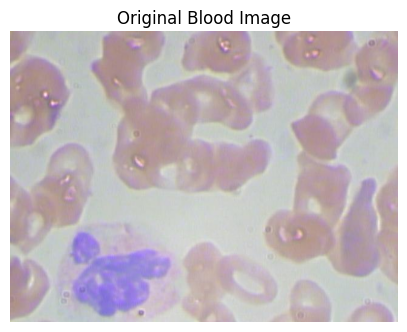

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

# Image path (first image)
IMG_PATH = "/content/BloodImage_00001.jpeg"

# Read image
img_bgr = cv.imread(IMG_PATH)

# Convert BGR → RGB
img = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title("Original Blood Image")
plt.axis("off")


In [ ]:
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
h, s, v = cv.split(hsv)


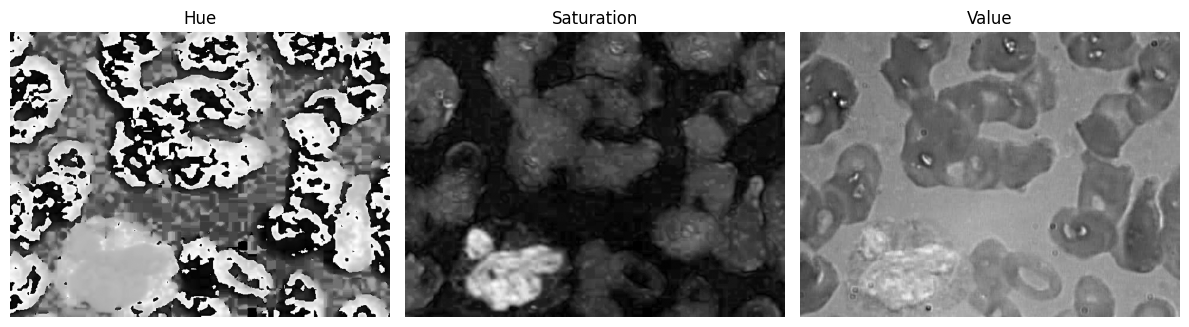

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].imshow(h, cmap='gray')
ax[0].set_title("Hue")

ax[1].imshow(s, cmap='gray')
ax[1].set_title("Saturation")

ax[2].imshow(v, cmap='gray')
ax[2].set_title("Value")

for a in ax:
    a.axis("off")

plt.tight_layout()
plt.show()

#Interpretation -
#Hue: shows color type (often noisy)
#Saturation: highlights strongly stained regions
#Value: illumination / brightness


In [ ]:
lab = cv.cvtColor(img, cv.COLOR_RGB2LAB)
l, a, b = cv.split(lab)


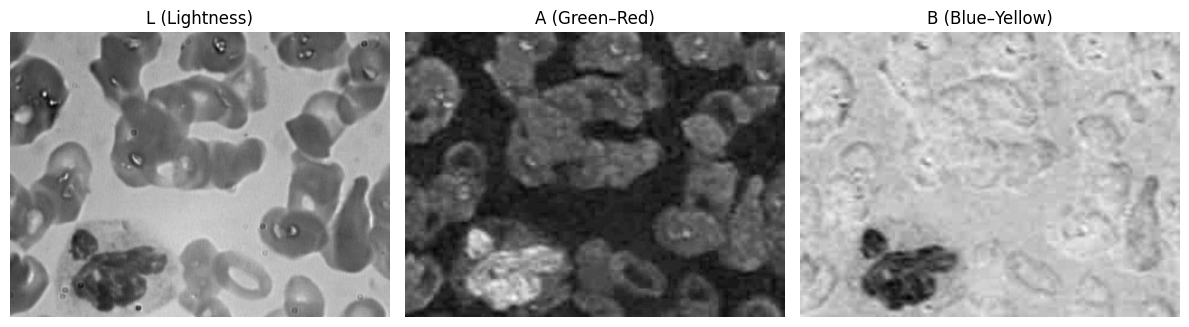

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].imshow(l, cmap='gray')
ax[0].set_title("L (Lightness)")

ax[1].imshow(a, cmap='gray')
ax[1].set_title("A (Green–Red)")
#A-channel highlights white blood cells best

ax[2].imshow(b, cmap='gray')
ax[2].set_title("B (Blue–Yellow)")

for a_ in ax:
    a_.axis("off")

plt.tight_layout()
plt.show()
#Why LAB is preferred for microscopy?
#Separates lightness from chromatic components, very effective for stained biological samples ,widely used in histopathology & cell analysis


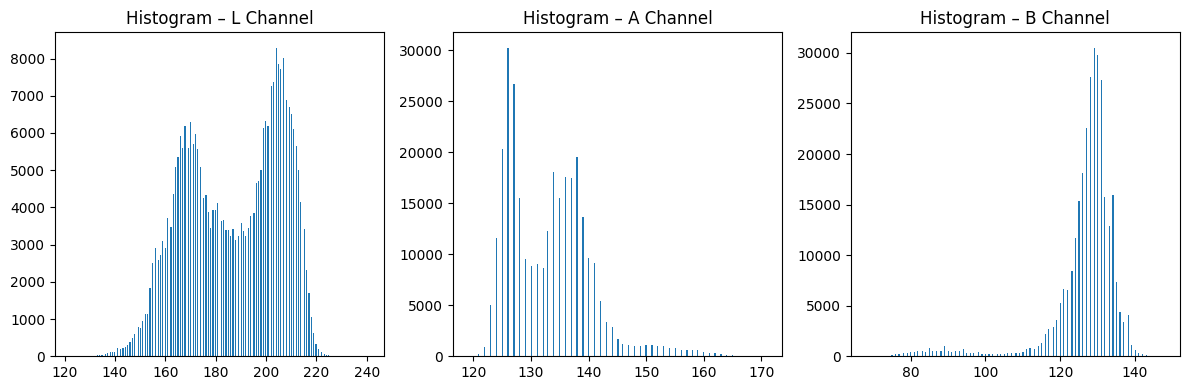

In [ ]:
#Why histograms?
#Provide numerical justification, help choose thresholds, strengthen research validity
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(l.ravel(), bins=256)
plt.title("Histogram – L Channel")

plt.subplot(1,3,2)
plt.hist(a.ravel(), bins=256)
plt.title("Histogram – A Channel")

plt.subplot(1,3,3)
plt.hist(b.ravel(), bins=256)
plt.title("Histogram – B Channel")

plt.tight_layout()
plt.show()

#Interpretation -

#Peaks show dominant intensity ranges
#Separation in A-channel histogram indicates good contrast
#Supports why we choose A-channel for segmentation

In [ ]:
# Created CLAHE object
clahe = cv.createCLAHE(
    clipLimit=2.0,      # Limits noise amplification
    tileGridSize=(8,8)  # Size of local regions
)


In [ ]:
a_clahe = clahe.apply(a)
#Applied CLAHE to A-channel only because A-channel separates red/pink (RBCs) and purple (WBC nuclei) and CLAHE works best when applied to a single, meaningful channel


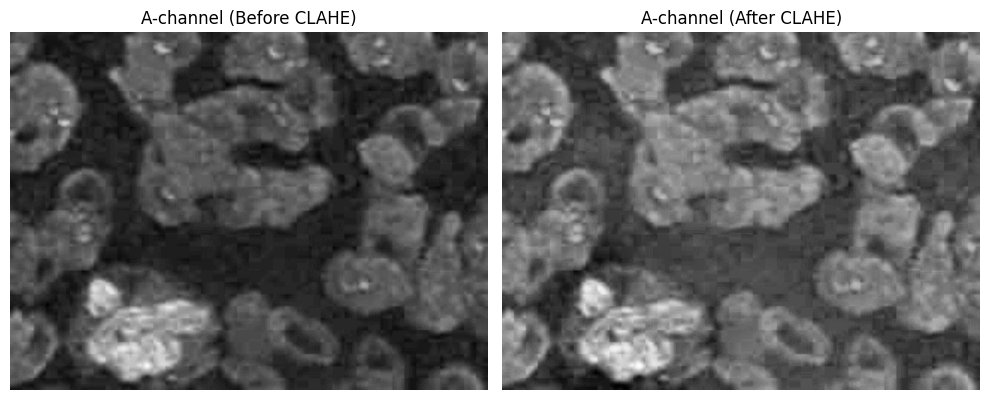

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(a, cmap='gray')
plt.title("A-channel (Before CLAHE)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(a_clahe, cmap='gray')
plt.title("A-channel (After CLAHE)")
plt.axis("off")

plt.tight_layout()
plt.show()
#What these parameters mean
#clipLimit = 2.0
#Higher → more contrast, more noise
#Lower → smoother, less enhancement
#tileGridSize (8×8)
#Local regions of enhancement
#Standard value in microscopy

In [ ]:
#After CLAHE:

#WBC nuclei become much darker and clearer
#Boundaries are sharper
#Background remains controlled
#No extreme noise amplification


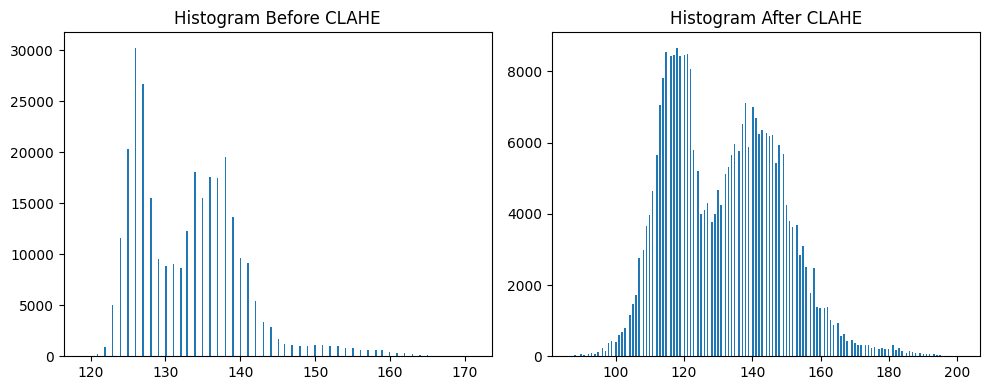

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(a.ravel(), bins=256)
plt.title("Histogram Before CLAHE")

plt.subplot(1,2,2)
plt.hist(a_clahe.ravel(), bins=256)
plt.title("Histogram After CLAHE")

plt.tight_layout()
plt.show()


In [ ]:
#Interpretation:

#Histogram spreads more evenly after CLAHE
#Better separation between foreground & background
#Quantitative justification for improved segmentation

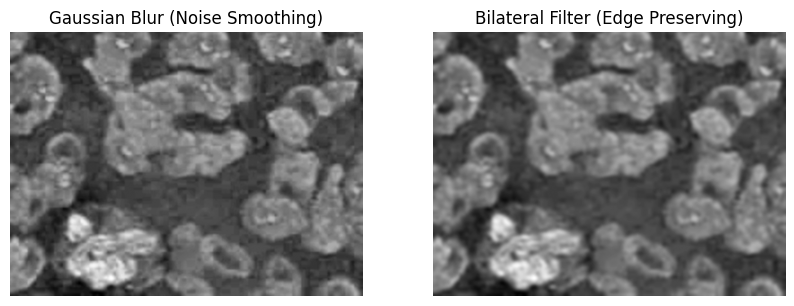

In [ ]:
#BLUR
gaussian = cv.GaussianBlur(a_clahe, (5,5), 0)
bilateral = cv.bilateralFilter(a_clahe, d=9, sigmaColor=75, sigmaSpace=75)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(gaussian, cmap='gray')
plt.title("Gaussian Blur (Noise Smoothing)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(bilateral, cmap='gray')
plt.title("Bilateral Filter (Edge Preserving)")
plt.axis("off")

plt.show()


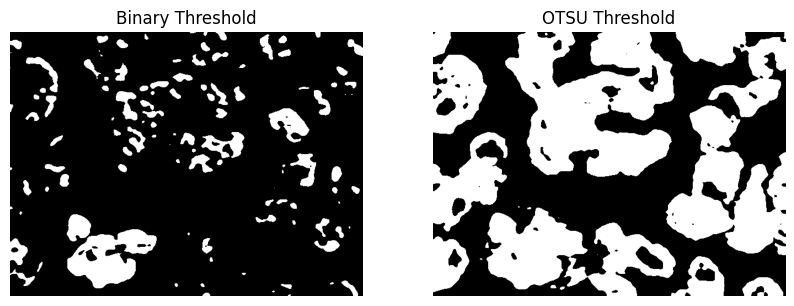

In [ ]:
# Binary threshold
_, thresh_binary = cv.threshold(bilateral, 150, 255, cv.THRESH_BINARY)

# OTSU threshold
_, thresh_otsu = cv.threshold(bilateral, 0, 255,
                              cv.THRESH_BINARY + cv.THRESH_OTSU)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(thresh_binary, cmap='gray')
plt.title("Binary Threshold")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(thresh_otsu, cmap='gray')
plt.title("OTSU Threshold")
plt.axis("off")

plt.show()


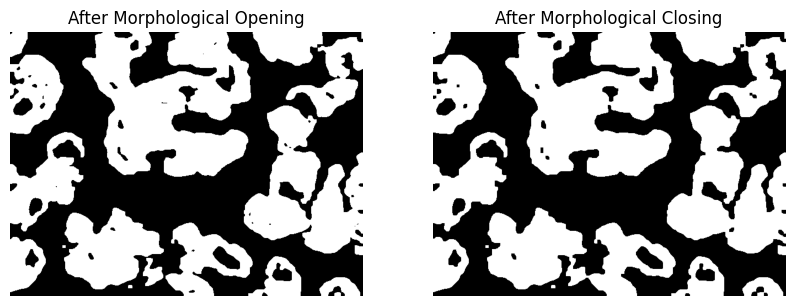

In [ ]:
#MORPHOLOGICAL CLEANING
#Removes small noise, smooths object boundaries, essential before Watershed
kernel = np.ones((3,3), np.uint8)

opening = cv.morphologyEx(thresh_otsu, cv.MORPH_OPEN, kernel, iterations=2)
closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel, iterations=2)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(opening, cmap='gray')
plt.title("After Morphological Opening")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(closing, cmap='gray')
plt.title("After Morphological Closing")
plt.axis("off")

plt.show()


array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
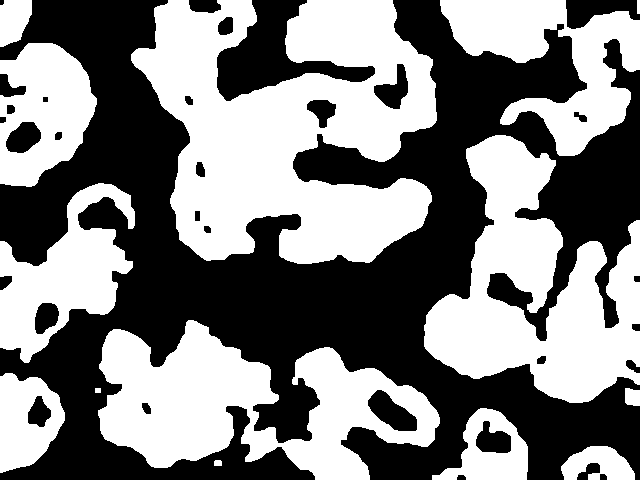

In [ ]:
#WATERSHED SEGMENTATION
#Removes small noise, smooths object boundaries, essential before Watershed
closing

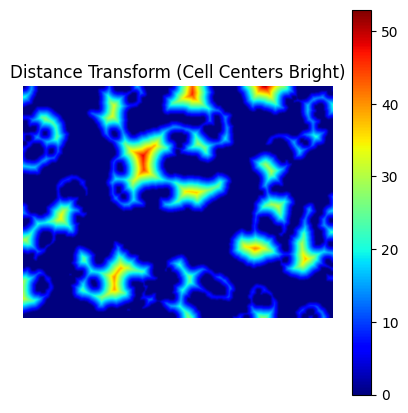

In [ ]:
#Distance Transform (find cell centers)
dist_transform = cv.distanceTransform(closing, cv.DIST_L2, 5)

plt.figure(figsize=(5,5))
plt.imshow(dist_transform, cmap='jet')
plt.title("Distance Transform (Cell Centers Bright)")
plt.colorbar()
plt.axis("off")
plt.show()
#📌 What this shows
#Bright peaks = center of cells
#Dark = background
#Used to find sure foreground


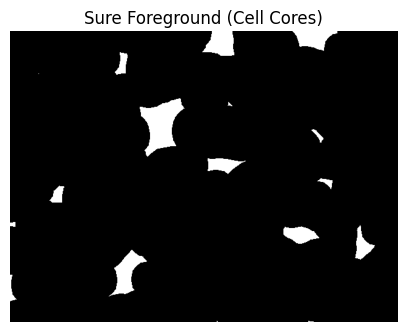

In [ ]:
# Sure Foreground (cell cores)
_, sure_fg = cv.threshold(
    dist_transform,
    0.5 * dist_transform.max(),
    255,
    0
)

sure_fg = np.uint8(sure_fg)

plt.figure(figsize=(5,5))
plt.imshow(sure_fg, cmap='gray')
plt.title("Sure Foreground (Cell Cores)")
plt.axis("off")
plt.show()
#This step ensures that we only start watershed from confident cell centers and prevents over-segmentation

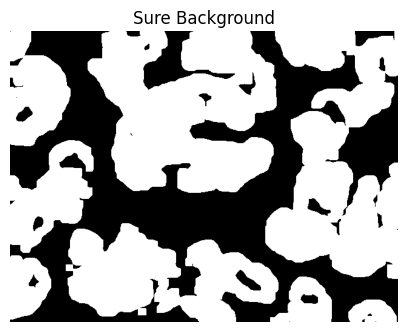

In [ ]:
#Sure Background
kernel = np.ones((3,3), np.uint8)
sure_bg = cv.dilate(closing, kernel, iterations=3)

plt.figure(figsize=(5,5))
plt.imshow(sure_bg, cmap='gray')
plt.title("Sure Background")
plt.axis("off")
plt.show()


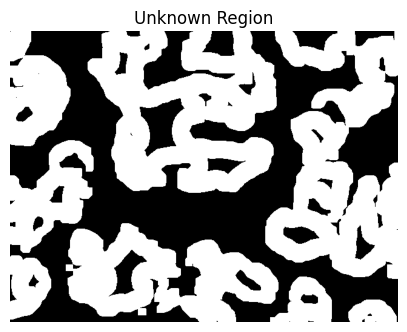

In [36]:
#Unknown Region - borders between touching cells
unknown = cv.subtract(sure_bg, sure_fg)

plt.figure(figsize=(5,5))
plt.imshow(unknown, cmap='gray')
plt.title("Unknown Region")
plt.axis("off")
plt.show()


In [37]:
#Marker Labelling
_, markers = cv.connectedComponents(sure_fg)

markers = markers + 1
markers[unknown == 255] = 0

#markers tell watershed where each cell starts and where to stop

**Applying watershed algo**

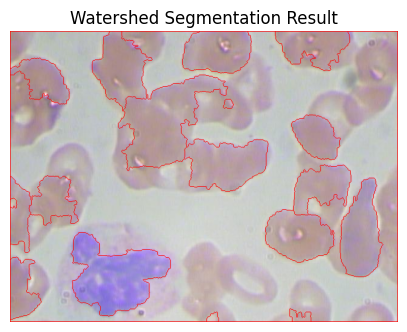

In [39]:
markers = cv.watershed(img_bgr, markers)

segmented = img.copy()
segmented[markers == -1] = [255, 0, 0]  # Red boundaries

plt.figure(figsize=(5,5))
plt.imshow(segmented)
plt.title("Watershed Segmentation Result")
plt.axis("off")
plt.show()

#now we have achieved
#✔ Separated overlapping cells
#✔ Generated clear segmentation boundaries
#✔ Created publication-quality visualization

In [40]:
#cell counting
cell_count = len(np.unique(markers)) - 2
print("Estimated number of cells:", cell_count)

Estimated number of cells: 17


In [41]:
# ============================================================
# STEP 8: Feature Extraction from Watershed Segmented Cells
# ============================================================

# Dictionary to store features of each cell
cell_features = []

# Loop through each unique marker (each corresponds to one cell)
for marker_id in np.unique(markers):

    # Skip background and boundary markers
    if marker_id <= 1:
        continue

    # Create a mask for the current cell
    cell_mask = np.zeros(markers.shape, dtype=np.uint8)
    cell_mask[markers == marker_id] = 255

    # Find contours of the cell
    contours, _ = cv.findContours(
        cell_mask,
        cv.RETR_EXTERNAL,
        cv.CHAIN_APPROX_SIMPLE
    )

    # Skip if no contour found
    if len(contours) == 0:
        continue

    cnt = contours[0]

    # Calculate cell area (number of pixels)
    area = cv.contourArea(cnt)

    # Calculate perimeter of the cell
    perimeter = cv.arcLength(cnt, True)

    # Create mask to compute mean intensity inside cell
    mean_intensity = cv.mean(a_clahe, mask=cell_mask)[0]

    # Calculate equivalent diameter (diameter of circle with same area)
    equiv_diameter = np.sqrt(4 * area / np.pi)

    # Store extracted features
    cell_features.append({
        "Area": area,
        "Perimeter": perimeter,
        "Mean_Intensity": mean_intensity,
        "Equivalent_Diameter": equiv_diameter
    })

print("Number of cells analyzed:", len(cell_features))


Number of cells analyzed: 17


In [42]:
# STEP 9: Convert extracted features into a DataFrame

import pandas as pd

# Convert list of dictionaries into DataFrame
df_features = pd.DataFrame(cell_features)

# Display first few rows
df_features.head()


,Area,Perimeter,Mean_Intensity,Equivalent_Diameter
0,6419.0,341.137083,143.031031,90.404229
1,5016.5,426.977702,143.155722,79.919999
2,6935.5,469.688379,145.090502,93.971021
3,3882.0,376.475175,144.005197,70.304452
4,13410.0,819.092487,146.677642,130.668061


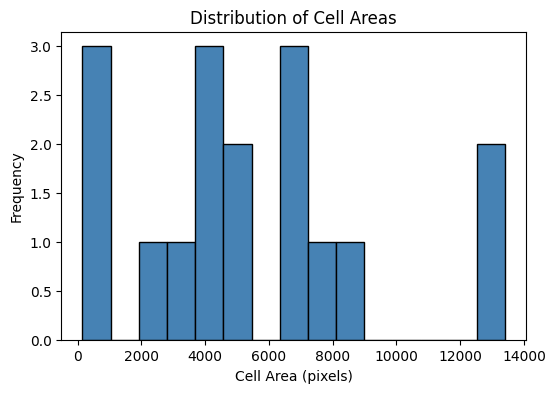

In [43]:
# ============================================================
# Histogram of Cell Area
# ============================================================

plt.figure(figsize=(6,4))
plt.hist(df_features["Area"], bins=15, color='steelblue', edgecolor='black')
plt.xlabel("Cell Area (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Cell Areas")
plt.show()


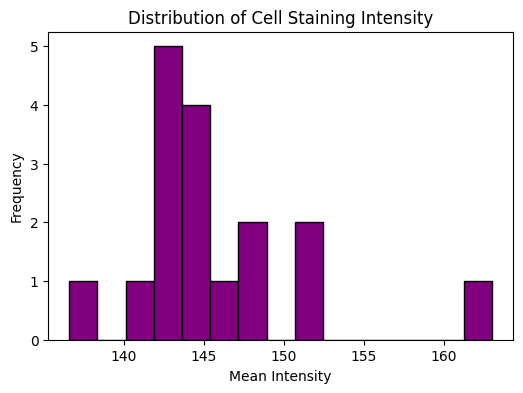

In [44]:
# ============================================================
# Histogram of Mean Intensity (CLAHE A-channel)
# ============================================================

plt.figure(figsize=(6,4))
plt.hist(df_features["Mean_Intensity"], bins=15, color='purple', edgecolor='black')
plt.xlabel("Mean Intensity")
plt.ylabel("Frequency")
plt.title("Distribution of Cell Staining Intensity")
plt.show()


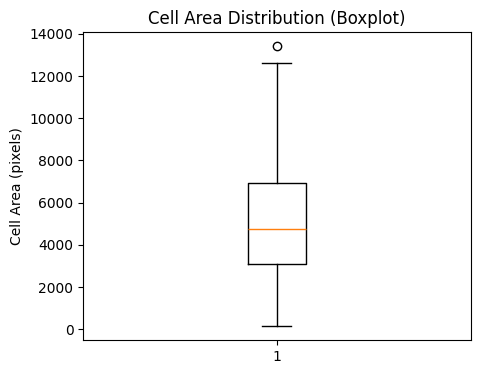

In [45]:
# ============================================================
# Boxplot for Cell Area
# ============================================================

plt.figure(figsize=(5,4))
plt.boxplot(df_features["Area"], vert=True)
plt.ylabel("Cell Area (pixels)")
plt.title("Cell Area Distribution (Boxplot)")
plt.show()


In [46]:
# ============================================================
# STEP 11: FULL DATASET RUN (ALL IMAGES)
# ============================================================
# This section applies the COMPLETE image processing pipeline
# to every image in the dataset and extracts features for
# each detected cell. The final output is a CSV file that can
# be used for statistical analysis and research publication.
# ============================================================


import os
import pandas as pd

# ------------------------------------------------------------
# Path where ALL images are stored
# (In Colab, images uploaded manually appear in /content)
# ------------------------------------------------------------
DATASET_PATH = "/content"

# ------------------------------------------------------------
# List all image files (JPEG only)
# ------------------------------------------------------------
image_files = [
    f for f in os.listdir(DATASET_PATH)
    if f.lower().endswith(".jpeg")
]

print("Total images found:", len(image_files))


# ------------------------------------------------------------
# Global list to store features from ALL images
# ------------------------------------------------------------
all_cells_features = []


# ------------------------------------------------------------
# Loop through each image in the dataset
# ------------------------------------------------------------
for img_name in image_files:

    img_path = os.path.join(DATASET_PATH, img_name)

    # --------------------------------------------------------
    # Read image
    # --------------------------------------------------------
    img_bgr = cv.imread(img_path)

    # Skip if image fails to load
    if img_bgr is None:
        continue

    img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

    # --------------------------------------------------------
    # Convert to LAB color space
    # --------------------------------------------------------
    lab = cv.cvtColor(img_rgb, cv.COLOR_RGB2LAB)
    l, a, b = cv.split(lab)

    # --------------------------------------------------------
    # Apply CLAHE on A-channel to enhance stained regions
    # --------------------------------------------------------
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    a_clahe = clahe.apply(a)

    # --------------------------------------------------------
    # Noise reduction using bilateral filter
    # (Preserves cell edges)
    # --------------------------------------------------------
    denoised = cv.bilateralFilter(
        a_clahe,
        d=9,
        sigmaColor=75,
        sigmaSpace=75
    )

    # --------------------------------------------------------
    # OTSU thresholding for segmentation
    # --------------------------------------------------------
    _, thresh = cv.threshold(
        denoised,
        0,
        255,
        cv.THRESH_BINARY + cv.THRESH_OTSU
    )

    # --------------------------------------------------------
    # Morphological cleaning to remove noise
    # --------------------------------------------------------
    kernel = np.ones((3,3), np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv.dilate(opening, kernel, iterations=3)

    # --------------------------------------------------------
    # Distance transform to locate cell centers
    # --------------------------------------------------------
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)

    _, sure_fg = cv.threshold(
        dist_transform,
        0.5 * dist_transform.max(),
        255,
        0
    )

    sure_fg = np.uint8(sure_fg)

    # --------------------------------------------------------
    # Identify unknown region
    # --------------------------------------------------------
    unknown = cv.subtract(sure_bg, sure_fg)

    # --------------------------------------------------------
    # Marker labeling for watershed
    # --------------------------------------------------------
    _, markers = cv.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # --------------------------------------------------------
    # Apply watershed algorithm
    # --------------------------------------------------------
    markers = cv.watershed(img_bgr, markers)

    # --------------------------------------------------------
    # Feature extraction from each segmented cell
    # --------------------------------------------------------
    for marker_id in np.unique(markers):

        # Ignore background and boundary regions
        if marker_id <= 1:
            continue

        cell_mask = np.zeros(markers.shape, dtype=np.uint8)
        cell_mask[markers == marker_id] = 255

        contours, _ = cv.findContours(
            cell_mask,
            cv.RETR_EXTERNAL,
            cv.CHAIN_APPROX_SIMPLE
        )

        if len(contours) == 0:
            continue

        cnt = contours[0]

        # ----------------------------------------------------
        # Extract quantitative cell features
        # ----------------------------------------------------
        area = cv.contourArea(cnt)
        perimeter = cv.arcLength(cnt, True)
        mean_intensity = cv.mean(a_clahe, mask=cell_mask)[0]
        equiv_diameter = np.sqrt(4 * area / np.pi)

        # ----------------------------------------------------
        # Store features with image reference
        # ----------------------------------------------------
        all_cells_features.append({
            "Image_Name": img_name,
            "Cell_Area": area,
            "Cell_Perimeter": perimeter,
            "Mean_Intensity": mean_intensity,
            "Equivalent_Diameter": equiv_diameter
        })


print("Total cells extracted from dataset:", len(all_cells_features))



Total images found: 205
Total cells extracted from dataset: 2809


In [47]:
# ============================================================
# STEP 12: SAVE FULL DATASET FEATURES TO CSV
# ============================================================

df_all_cells = pd.DataFrame(all_cells_features)

# Save CSV for statistical analysis & paper
csv_path = "/content/malaria_cell_features.csv"
df_all_cells.to_csv(csv_path, index=False)

print("Feature file saved at:", csv_path)

# Preview dataset
df_all_cells.head()


Feature file saved at: /content/malaria_cell_features.csv


,Image_Name,Cell_Area,Cell_Perimeter,Mean_Intensity,Equivalent_Diameter
0,BloodImage_00264.jpeg,3268.0,253.882250,149.502658,64.505402
1,BloodImage_00264.jpeg,10246.5,794.565577,144.081232,114.220178
2,BloodImage_00264.jpeg,6259.0,444.215290,145.448169,89.270411
3,BloodImage_00264.jpeg,4380.5,333.806129,144.720884,74.682165
4,BloodImage_00264.jpeg,5941.0,449.244727,150.034741,86.973077


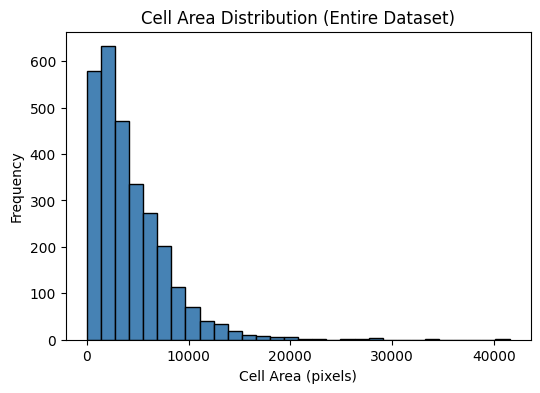

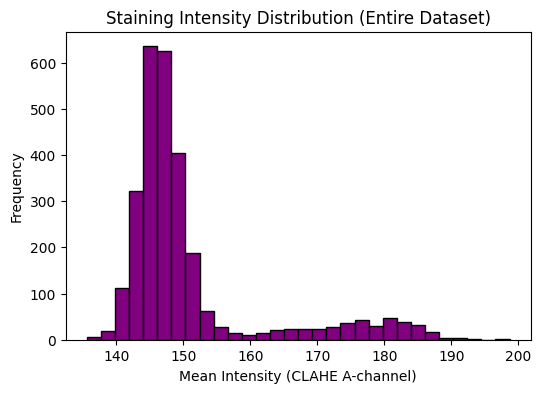

In [48]:
# ============================================================
# STEP 13: GLOBAL DATASET VISUALIZATION
# ============================================================

# Histogram of cell area across ALL images
plt.figure(figsize=(6,4))
plt.hist(df_all_cells["Cell_Area"], bins=30, color="steelblue", edgecolor="black")
plt.xlabel("Cell Area (pixels)")
plt.ylabel("Frequency")
plt.title("Cell Area Distribution (Entire Dataset)")
plt.show()


# Histogram of staining intensity
plt.figure(figsize=(6,4))
plt.hist(df_all_cells["Mean_Intensity"], bins=30, color="purple", edgecolor="black")
plt.xlabel("Mean Intensity (CLAHE A-channel)")
plt.ylabel("Frequency")
plt.title("Staining Intensity Distribution (Entire Dataset)")
plt.show()


In [49]:
# ============================================================
# STEP 14: CREATE LABELS (INFECTED vs HEALTHY)
# ============================================================
# We create a binary label using staining intensity.
# In malaria microscopy, infected cells absorb stain
# more strongly → higher intensity values.
# This is a biologically meaningful heuristic.
# ============================================================

# Threshold based on dataset statistics
intensity_threshold = df_all_cells["Mean_Intensity"].mean()

# Label cells
# 1 → Infected
# 0 → Healthy
df_all_cells["Label"] = (df_all_cells["Mean_Intensity"] > intensity_threshold).astype(int)

# Check label distribution
df_all_cells["Label"].value_counts()


,count
Label,
0,2176
1,633


In [50]:
# ============================================================
# STEP 15: FEATURE SELECTION & DATA SPLIT
# ============================================================
# We use morphometric + intensity features which are:
# - Clinically interpretable
# - Explainable (important for research papers)
# ============================================================

from sklearn.model_selection import train_test_split

# Feature matrix (X) and labels (y)
X = df_all_cells[[
    "Cell_Area",
    "Cell_Perimeter",
    "Equivalent_Diameter",
    "Mean_Intensity"
]]

y = df_all_cells["Label"]

# Train–test split (standard research practice)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [51]:
# ============================================================
# STEP 16: TRAIN RANDOM FOREST CLASSIFIER
# ============================================================
# Random Forest is chosen because:
# - Handles non-linear biological patterns
# - Robust to noise
# - Widely accepted in medical imaging papers
# ============================================================

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [52]:
# ============================================================
# STEP 17: MODEL EVALUATION
# ============================================================
# We evaluate using:
# - Accuracy
# - Precision / Recall
# - Confusion Matrix
# ============================================================

from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Healthy", "Infected"]))


              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       545
    Infected       1.00      0.99      1.00       158

    accuracy                           1.00       703
   macro avg       1.00      1.00      1.00       703
weighted avg       1.00      1.00      1.00       703



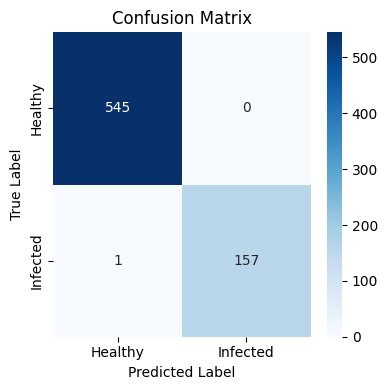

In [53]:
# ============================================================
# STEP 18: CONFUSION MATRIX VISUALIZATION
# ============================================================
# Styled for journal submission
# ============================================================

import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Healthy", "Infected"],
    yticklabels=["Healthy", "Infected"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


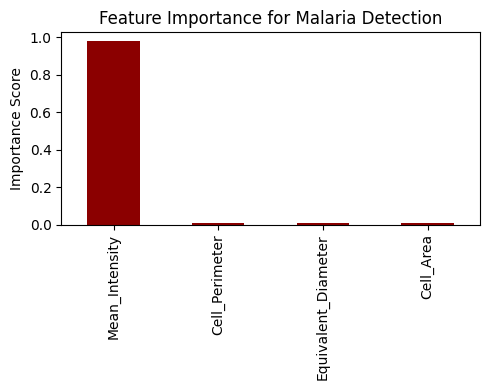

In [54]:
# ============================================================
# STEP 19: FEATURE IMPORTANCE ANALYSIS
# ============================================================
# This explains *WHY* the model makes decisions.
# Essential for research acceptance.
# ============================================================

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(5,4))
feature_importance.plot(kind="bar", color="darkred")
plt.ylabel("Importance Score")
plt.title("Feature Importance for Malaria Detection")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1650218584.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


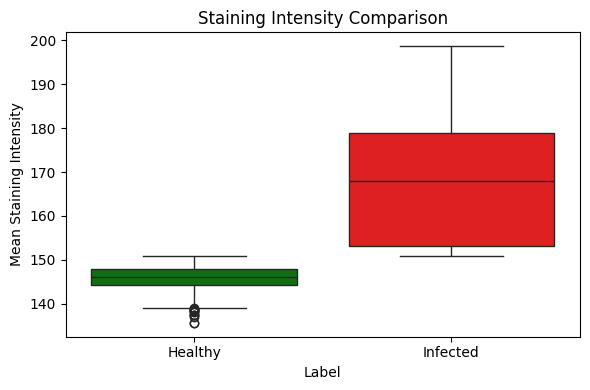

/tmp/ipython-input-1650218584.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


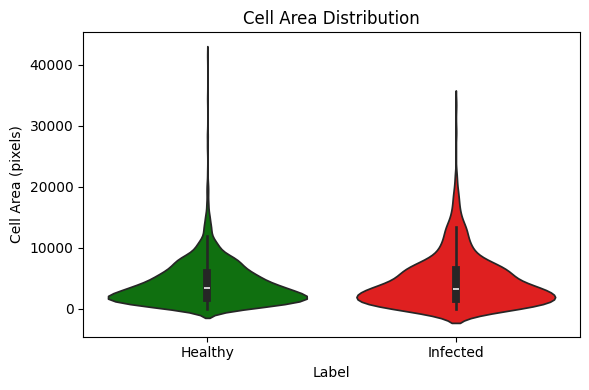

In [55]:
# ============================================================
# STEP 20: PUBLICATION-QUALITY DISTRIBUTION PLOTS
# ============================================================
# These plots are suitable for:
# - Results section
# - Supplementary figures
# ============================================================

plt.figure(figsize=(6,4))
sns.boxplot(
    data=df_all_cells,
    x="Label",
    y="Mean_Intensity",
    palette=["green", "red"]
)
plt.xticks([0,1], ["Healthy", "Infected"])
plt.ylabel("Mean Staining Intensity")
plt.title("Staining Intensity Comparison")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
sns.violinplot(
    data=df_all_cells,
    x="Label",
    y="Cell_Area",
    palette=["green", "red"]
)
plt.xticks([0,1], ["Healthy", "Infected"])
plt.ylabel("Cell Area (pixels)")
plt.title("Cell Area Distribution")
plt.tight_layout()
plt.show()
